### 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import seaborn as sns

### 3. Dataset Path and Parameters

In [3]:
data_dir = "/content/drive/MyDrive/Autism Images"
IMG_SIZE = 224
BATCH_SIZE = 16

### 4. Load Dataset

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

Found 547 files belonging to 2 classes.
Using 438 files for training.
Found 547 files belonging to 2 classes.
Using 109 files for validation.


### 5. Preprocessing

In [5]:
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))

### 6. Load EfficientNetV2-Small Base

In [6]:
base_model = EfficientNetV2S(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False   # Freeze base

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### 7. Build Final Model

In [7]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

### 8. Compile Model

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### 9. Early Stopping

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

### 10. Train Model

In [10]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6192 - loss: 0.6599 - val_accuracy: 0.7431 - val_loss: 0.5786
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7253 - loss: 0.5757 - val_accuracy: 0.7431 - val_loss: 0.5469
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6871 - loss: 0.5723 - val_accuracy: 0.7431 - val_loss: 0.5387
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7608 - loss: 0.5383 - val_accuracy: 0.7523 - val_loss: 0.5356
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.7446 - loss: 0.5117 - val_accuracy: 0.7523 - val_loss: 0.5370
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7642 - loss: 0.4936 - val_accuracy: 0.7339 - val_loss: 0.5386
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7773 - loss: 0.4930 - val_accuracy: 0.7339 - val_loss: 0.5376


### TEST EVALUATION METRICS

In [11]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)   # Sensitivity
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Accuracy: 0.7522935779816514
Precision: 0.75
Recall (Sensitivity): 0.5581395348837209
F1 Score: 0.64
MCC: 0.46891609306434945


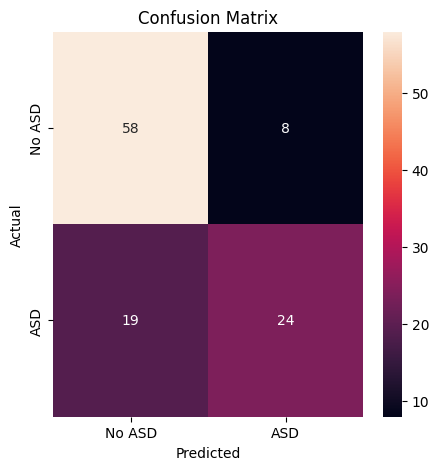

In [12]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["No ASD", "ASD"],
            yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

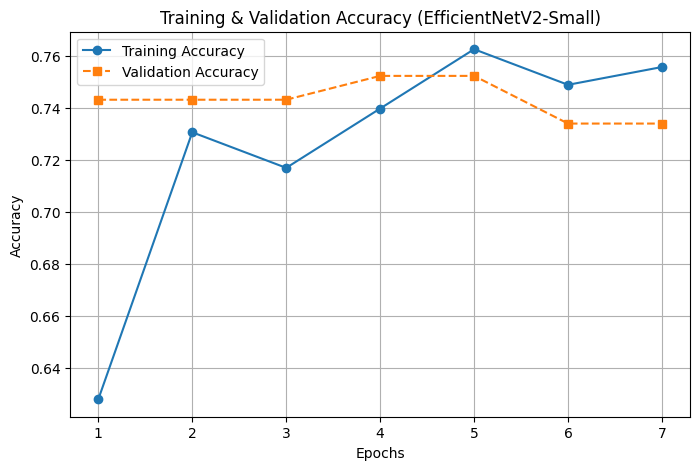

In [13]:
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs_range, history.history['accuracy'], marker='o', linestyle='-')
plt.plot(epochs_range, history.history['val_accuracy'], marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy (EfficientNetV2-Small)')
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

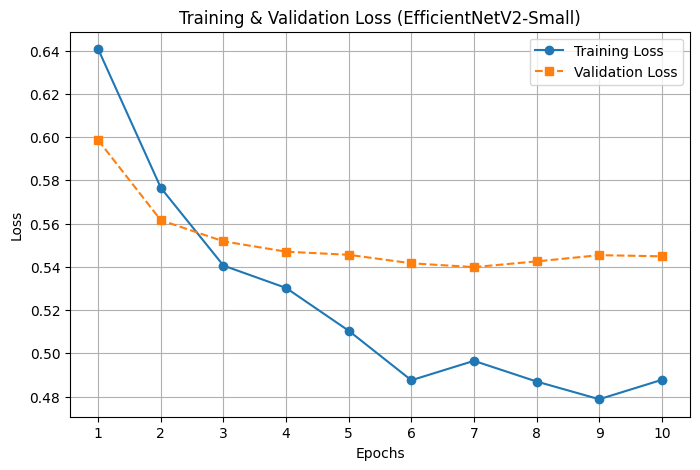

In [14]:

# Loss
plt.figure(figsize=(8,5))
plt.plot(epochs_range, history.history['loss'], marker='o', linestyle='-')
plt.plot(epochs_range, history.history['val_loss'], marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (EfficientNetV2-Small)')
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(['Training Loss','Validation Loss'])
plt.show()